## Data
https://www.kaggle.com/datasets/puneet6060/intel-image-classification

In [2]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm

In [3]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}


nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

class_names_label

{'mountain': 0,
 'street': 1,
 'glacier': 2,
 'buildings': 3,
 'sea': 4,
 'forest': 5}

In [5]:
import zipfile

zip_path = '/content/seg_test.zip'
extract_path = '/content/seg_test/'

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction successful!")
except zipfile.BadZipFile:
    print("Error: Bad ZIP file. Please verify that the file is not corrupted.")


Extraction successful!


In [6]:
import zipfile

zip_path = '/content/seg_train.zip'
extract_path = '/content/seg_train/'

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction successful!")
except zipfile.BadZipFile:
    print("Error: Bad ZIP file. Please verify that the file is not corrupted.")


Extraction successful!


In [4]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """

    datasets= ["/content/seg_train/seg_train",
              "/content/seg_test/seg_test"]

    output= []

    #Iterate throu training and test set
    for dataset in datasets:
        images= []
        labels= []
        print('Loading {}'.format(dataset))

        #Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            #Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                #get the path name of the image
                img_path= os.path.join(os.path.join(dataset, folder), file)

                #open and resize the image
                image = cv2.imread(img_path)
                if image is None:
                    print(f"Warning: Could not read image {img_path}")
                    continue
                image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image= cv2.resize(image, IMAGE_SIZE)

                #append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
        images= np.array(images, dtype='float32')
        labels= np.array(labels, dtype= 'int32')

        output.append((images, labels))
    return output



In [5]:
(train_images, train_labels), (test_images, test_labels)= load_data()

Loading /content/seg_train/seg_train


100%|██████████| 2191/2191 [00:01<00:00, 1179.37it/s]


Loading /content/seg_test/seg_test


100%|██████████| 437/437 [00:00<00:00, 1296.26it/s]


In [6]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [9]:
n_train= train_labels.shape[0]
n_test= test_labels.shape[0]

print("Number of training examples: {}".format(n_train))
print("Number of testing examples: {}".format(n_test))
print("Each image is of size: {}".format(IMAGE_SIZE))


Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


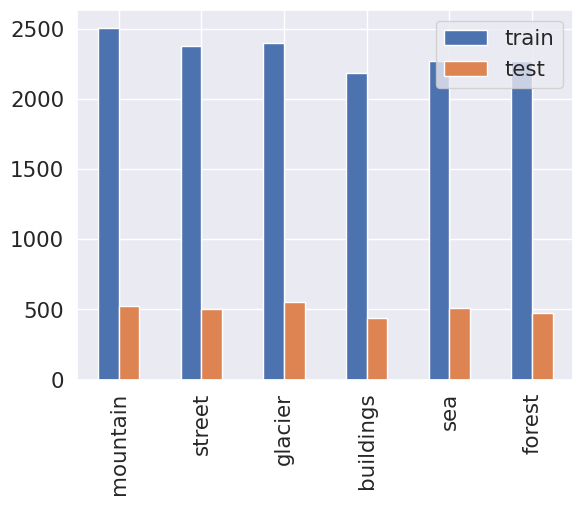

In [10]:
import pandas as pd

_, train_counts= np.unique(train_labels, return_counts= True)
_, test_counts= np.unique(test_labels, return_counts= True)
pd.DataFrame({'train': train_counts, 'test': test_counts}, index=class_names).plot.bar()
plt.show()

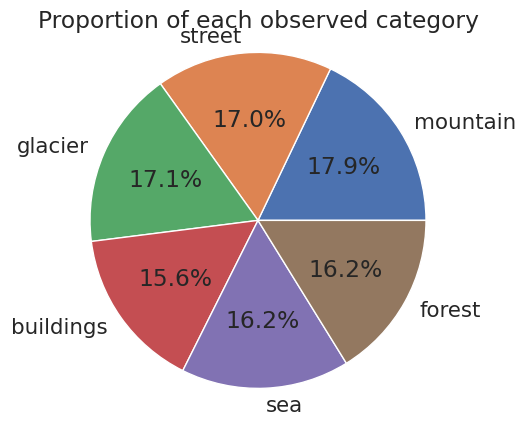

In [11]:
plt.pie(train_counts, explode= (0,0,0,0,0,0),
       labels= class_names,
       autopct= '%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [12]:
train_images= train_images/255.0
test_images= test_images/225.0

In [13]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """

    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

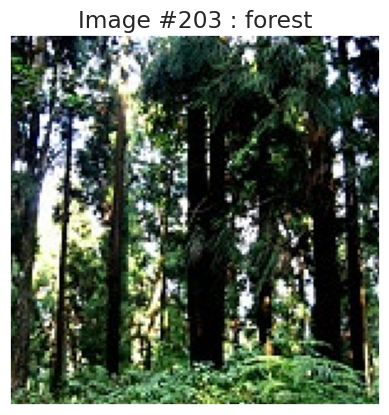

In [14]:
display_random_image(class_names, train_images, train_labels)

In [15]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """

    fig= plt.figure(figsize= (10, 10))
    fig.suptitle("Some example of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

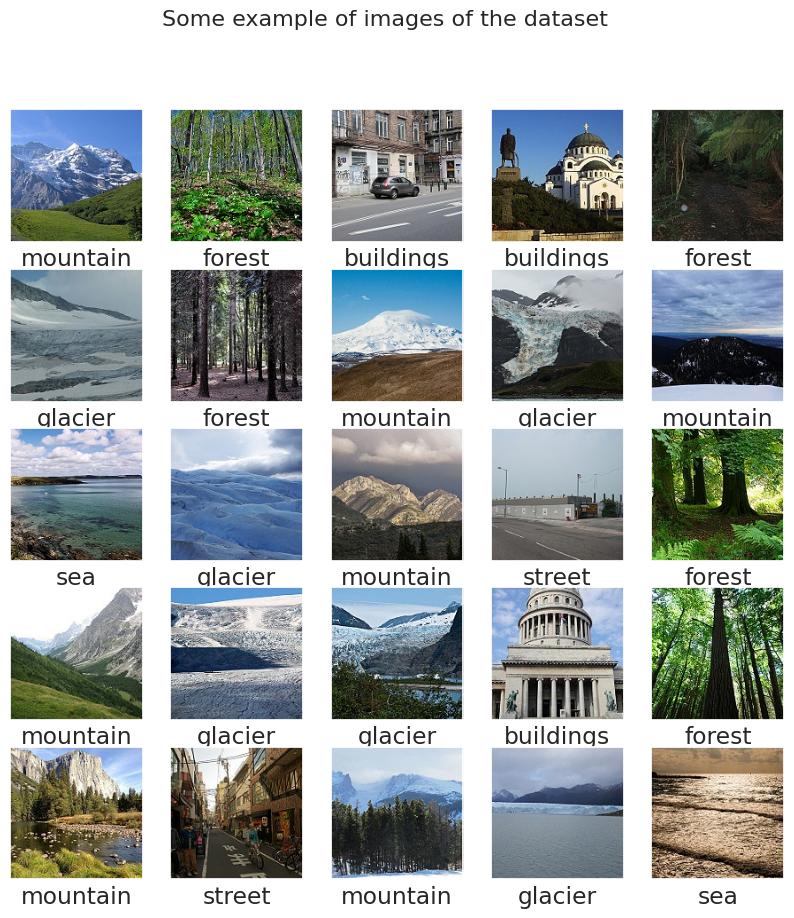

In [16]:
display_examples(class_names, train_images, train_labels)

In [17]:
model= tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation= 'relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3, 3), activation= 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation= 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation= 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation= tf.nn.relu),
    tf.keras.layers.Dense(64, activation= tf.nn.relu),
    tf.keras.layers.Dense(32, activation= tf.nn.softmax),
    tf.keras.layers.Dense(6, activation= tf.nn.softmax)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.compile(optimizer= 'adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])


In [19]:
history= model.fit(train_images, train_labels, batch_size= 50, epochs= 20, validation_split= 0.2)

Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.2783 - loss: 1.6907 - val_accuracy: 0.4090 - val_loss: 1.5540
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.4013 - loss: 1.5304 - val_accuracy: 0.4535 - val_loss: 1.4454
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.4617 - loss: 1.4326 - val_accuracy: 0.5262 - val_loss: 1.3102
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5105 - loss: 1.3016 - val_accuracy: 0.5354 - val_loss: 1.2209
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5398 - loss: 1.1929 - val_accuracy: 0.5454 - val_loss: 1.1527
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5461 - loss: 1.1317 - val_accuracy: 0.5525 - val_loss: 1.1025
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5726 - loss: 1.0591 - val_accuracy: 0.5415 - val_loss: 1.1044
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5805 - loss: 1.0060 - val

In [20]:
def plot_accuracy_loss(history):
    """
    Plot the accuracy and the loss during the training of the run.
    """
    fig = plt.figure(figsize=(10, 5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'], 'bo--', label="accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label="val_accuracy")
    plt.title("Train vs Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot loss
    plt.subplot(222)
    plt.plot(history.history["loss"], "bo--", label="loss")
    plt.plot(history.history["val_loss"], "ro--", label="val_loss")
    plt.title("Train vs Validation Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.show()


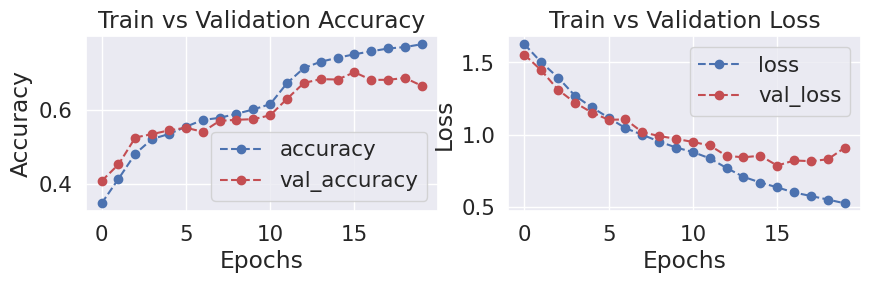

In [21]:
plot_accuracy_loss(history)

In [22]:
test_loss= model.evaluate(test_images, test_labels)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.4817 - loss: 0.9528


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


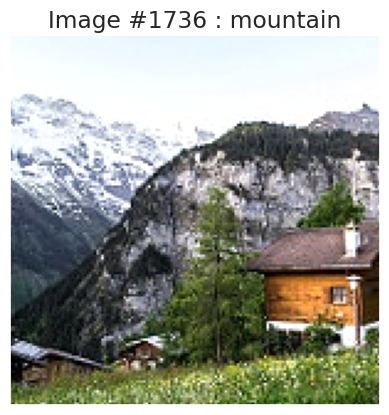

In [23]:
predictions= model.predict(test_images) # vector of probabalities
pred_labels= np.argmax(predictions, axis= 1) #we take highest probabilities

display_random_image(class_names, test_images, pred_labels)

In [24]:
def print_mislabeled_images(class_name, test_images, test_labels, pred_labels):
  """
    Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
  """

  BOO = (test_labels==pred_labels)
  mislabeled_indices= np.where(BOO==0)
  mislabeled_images= test_images[mislabeled_indices]
  mislabeled_labels= pred_labels[mislabeled_indices]

  title= "Some examples of mislabeled images by the classifer: "
  display_examples(class_name, mislabeled_images, mislabeled_labels)

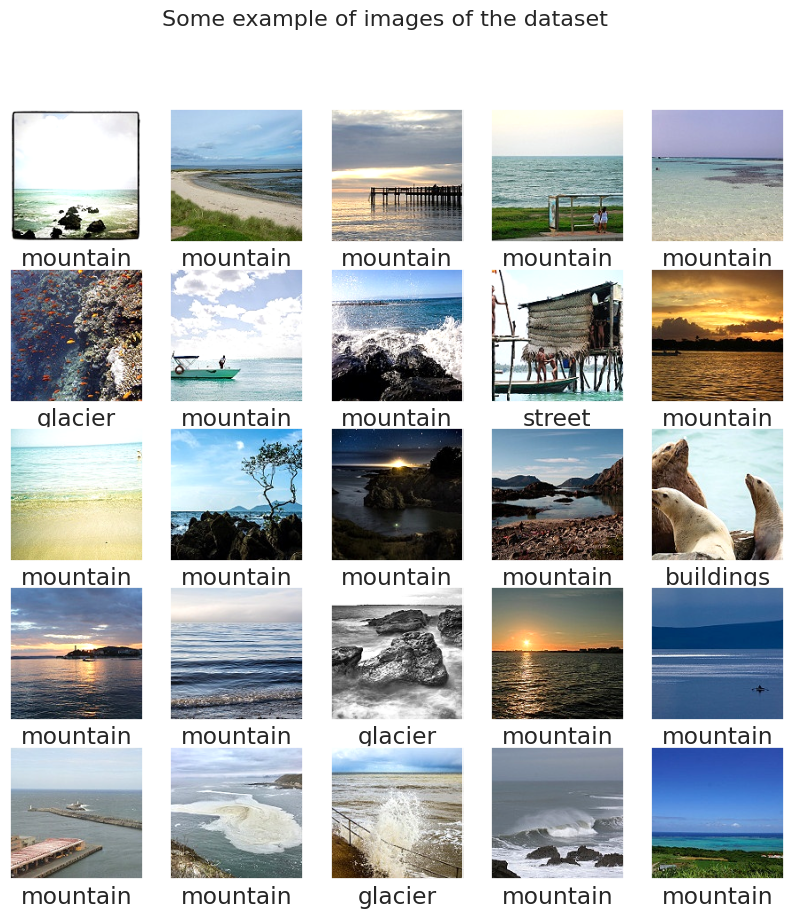

In [25]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

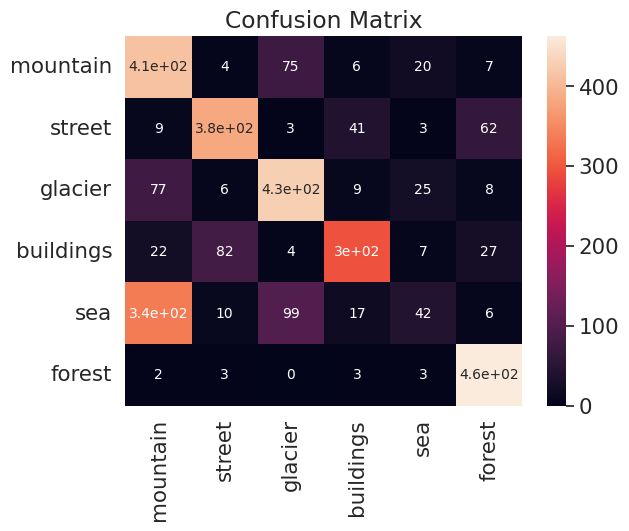

In [26]:
CM= confusion_matrix(test_labels, pred_labels)
ax= plt.axes()
sn.heatmap(CM, annot= True,
           annot_kws= {"size": 10},
           xticklabels= class_names,
           yticklabels= class_names, ax=ax)
ax.set_title('Confusion Matrix')
plt.show()